In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky
import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh
import lightcones.linalg as ll

In [2]:
class limiting_recursion:
    def __init__(self, dt, t_past, t_future, n_rel, n_iter, M_func=None, M_table=None):
        self.dt = dt
        self.n_t_past = int(t_past / dt)
        self.n_t_future = int(t_future / dt)
        self.t_max = t_past + t_future
        self.t = np.arange(0, self.t_max, dt)
        self.n_t_max = len(self.t)

        self.M = np.zeros(self.n_t_max)
        for i in range(self.n_t_max):
            if M_func is not None:
                self.M[i] = M_func(i * dt)
            if M_table is not None:
                self.M[i] = M_table[i]
    
        self.n_rel = n_rel
        self.n_iter = n_iter

    def apply_memory_matrix(self, x):
        x_out = np.zeros(self.n_t_past)
        for i in range(self.n_t_future):
            m = self.M[i:i+self.n_t_past]
            x_out = x_out + np.vdot(m, x) * m
        return x_out
    
    def get_memory_matrix(self):
        memory_matrix = sparse.linalg.LinearOperator((self.n_t_past, self.n_t_past), matvec=self.apply_memory_matrix)
        return memory_matrix
    
    def ensure_phase(self, eigenvectors):
        eigenvectors_corrected = eigenvectors.copy()
    
        for i in range(eigenvectors.shape[1]):
            v = eigenvectors[:, i]
            idx_max = np.argmax(np.abs(v))
        
            if v[idx_max] < 0:
                eigenvectors_corrected[:, i] = -v         

        return eigenvectors_corrected
    
    def get_relevant_modes(self):
        pi, v = eigsh(self.get_memory_matrix(), k=self.n_rel, which='LM')
        v = self.ensure_phase(v)
        return pi, v
    
    def compute_limiting_recursion(self):
        v_in = np.zeros(self.n_t_past)
        v_in[0] = 1

        memory_matrix = self.get_memory_matrix()
        pi, v = self.get_relevant_modes()

        def iterate(v):
            v_shifted = np.vstack((np.zeros(self.n_rel), v[:-1, :]))
            U = np.column_stack((v_in, v_shifted))
            rho = U.T.conj() @ (memory_matrix @ U)
            pi_, U_ = ll.find_eigs_descending(rho)
            U_ = self.ensure_phase(U_)
            v_ = U @ U_
            return pi_, U_, v_ 
        
        pi_lst = []
        U_lst = []
        v_lst = []

        v_ = np.copy(v)

        for i in range(self.n_iter):
            pi_, U_, v_ = iterate(v_)
            pi_lst.append(pi_)
            U_lst.append(U_)
            v_lst.append(v_)
            v_ = np.copy(v_)
            v_ = v_[:,:-1]

        self.pi = pi
        self.v = v

        self.pi_lst = pi_lst
        self.U_lst = U_lst
        self.v_lst = v_lst

        self.M_recursion = v_.T @ self.M[:self.n_t_past]  
        self.v_recusion = v_
        self.U_recursion = U_        

In [3]:
class noise_limiting_recursion:
    def __init__(self, dt, t_past, t_future, n_rel, n_iter, M_func=None, M_table=None):
        self.dt = dt
        self.n_t_past = int(t_past / dt)
        self.n_t_future = int(t_future / dt)
        self.t_max = t_past + t_future
        self.t = np.arange(0, self.t_max, dt)
        self.n_t_max = len(self.t)

        self.M = np.zeros(self.n_t_max + self.n_t_future) 
        for i in range(len(self.M)):
            if M_func is not None:
                self.M[i] = M_func(i * dt)
            if M_table is not None:
                self.M[i] = M_table[i]

        T = toeplitz(self.M)
        L = cholesky(T, lower=True)
        self.C = L[self.n_t_future:, self.n_t_future]
        self.recursion = limiting_recursion(dt, t_past, t_future, n_rel, n_iter, M_table=self.C)

In [4]:
class colored_noise:
    def __init__(self, dt, t_past, t_future, n_rel, n_iter, M_func=None, M_table=None):
        self.recursion = noise_limiting_recursion(dt, t_past, t_future, n_rel, n_iter, M_func, M_table)
        self.recursion.recursion.compute_limiting_recursion()

    def get_sample(self, n_t):
        xi = np.zeros(n_t)
        w = np.random.normal(size=n_t)
        v_state = np.zeros(self.recursion.recursion.n_rel)
        for i in range(0, n_t):
            v_in = w[i] 
            v_ = np.concatenate([[v_in], v_state])
            v_ = self.recursion.recursion.U_recursion.T.conj() @ v_
            v_state = v_[:-1]
            xi[i] = np.vdot(self.recursion.recursion.M_recursion, v_state)
        return xi


In [5]:
epsilon = 0.1
dt = 0.01
t_past = 40
t_future = 40 
n_rel = 10
n_iter = 1000

def M(t):
    return (epsilon**2 - t**2) / (epsilon**2 + t**2)**2

In [6]:
noise = colored_noise(dt, t_past, t_future, n_rel, n_iter, M_func=M)

In [8]:
mc_steps = 10000
n_t_corr = 400
corr = np.zeros((n_t_corr, n_t_corr))

n_t_max = int((t_past + t_future) / dt)

for m in range(mc_steps):
    xi = noise.get_sample(n_t_max)
    for p in range(n_t_corr):
        for q in range(n_t_corr):
            corr[p, q] += xi[p - n_t_corr + n_t_max] * xi[q - n_t_corr + n_t_max]
            
corr = corr / mc_steps  

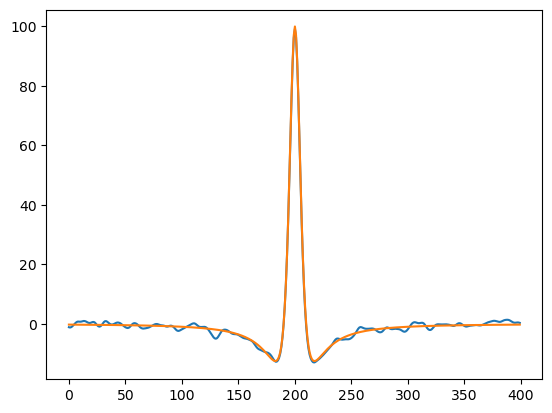

In [9]:
plt.plot(corr[round(n_t_corr/2), :])
plt.plot(np.concatenate((np.flip(noise.recursion.M[1:round(n_t_corr/2)+1]), noise.recursion.M[:round(n_t_corr/2)])))